# Explore here

In [1]:
import pandas as pd

In [2]:
URL = r'https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv'
df = pd.read_csv(URL)
df

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633
...,...,...
361,2023-08-30 17:10:08.079328,989.600354
362,2023-08-31 17:10:08.079328,994.987326
363,2023-09-01 17:10:08.079328,995.814415
364,2023-09-02 17:10:08.079328,997.350214


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    366 non-null    object 
 1   sales   366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


In [4]:
df.date = df.date.astype('datetime64[ns]')
df.set_index('date', drop=True, inplace=True)
df

,sales
date,
2022-09-03 17:10:08.079328,55.292157
2022-09-04 17:10:08.079328,53.803211
2022-09-05 17:10:08.079328,58.141693
2022-09-06 17:10:08.079328,64.530899
2022-09-07 17:10:08.079328,66.013633
...,...
2023-08-30 17:10:08.079328,989.600354
2023-08-31 17:10:08.079328,994.987326
2023-09-01 17:10:08.079328,995.814415


In [15]:
from sklearn.model_selection import train_test_split

In [21]:
train, test = train_test_split(df, test_size=0.2, shuffle=False)

In [33]:
test

,sales
date,
2023-06-22 17:10:08.079328,816.911750
2023-06-23 17:10:08.079328,809.422692
2023-06-24 17:10:08.079328,814.797630
2023-06-25 17:10:08.079328,821.218893
2023-06-26 17:10:08.079328,820.704134
...,...
2023-08-30 17:10:08.079328,989.600354
2023-08-31 17:10:08.079328,994.987326
2023-09-01 17:10:08.079328,995.814415


In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [23]:
decomposition = seasonal_decompose(train)

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

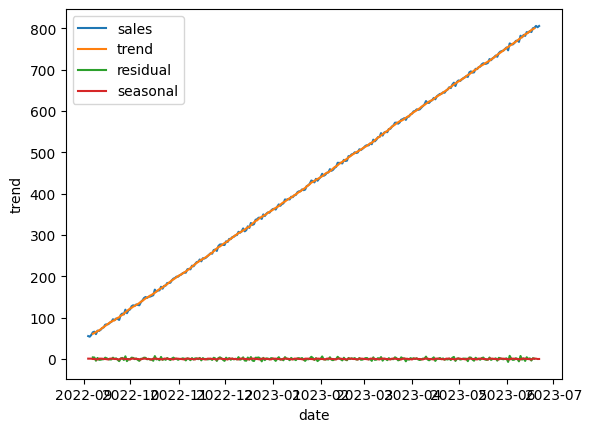

In [27]:
sns.lineplot(train)
sns.lineplot(decomposition.trend, label='trend')
sns.lineplot(decomposition.resid, label='residual')
sns.lineplot(decomposition.seasonal, label='seasonal')
plt.legend()
plt.show()

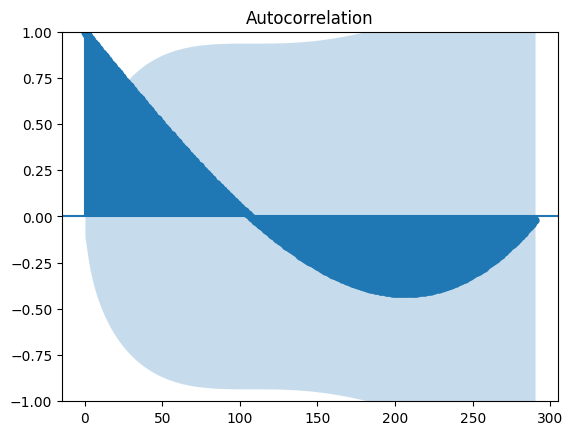

In [60]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(train,lags=290)
plt.show()

In [43]:
from statsmodels.tsa.stattools import adfuller

pvalue = adfuller(train, autolag='BIC')[1]

print(f'p-value: {pvalue}')

p-value: 0.9837961965731921


In [44]:
stationary_df = train.diff().dropna()
pvalue_diff = adfuller(stationary_df, autolag='BIC')[1]
print(f'p-value: {pvalue_diff}')

p-value: 1.1859398154284334e-23


In [ ]:
from pmdarima import auto_arima

In [48]:

model = auto_arima(train, seasonal = False, trace = True)

c:\Users\shade\OneDrive\Documentos\My coding projects\4geeks projects\venv312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\shade\OneDrive\Documentos\My coding projects\4geeks projects\venv312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\shade\OneDrive\Documentos\My coding projects\4geeks projects\venv312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\shade\OneDrive\Documentos\My coding projects\4geeks projects\venv312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.wa

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.81 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1675.428, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1578.564, Time=0.11 sec


c:\Users\shade\OneDrive\Documentos\My coding projects\4geeks projects\venv312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\shade\OneDrive\Documentos\My coding projects\4geeks projects\venv312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\shade\OneDrive\Documentos\My coding projects\4geeks projects\venv312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1475.165, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1763.761, Time=0.03 sec


c:\Users\shade\OneDrive\Documentos\My coding projects\4geeks projects\venv312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\shade\OneDrive\Documentos\My coding projects\4geeks projects\venv312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1475.512, Time=0.62 sec


c:\Users\shade\OneDrive\Documentos\My coding projects\4geeks projects\venv312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1475.495, Time=0.59 sec


c:\Users\shade\OneDrive\Documentos\My coding projects\4geeks projects\venv312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1479.028, Time=0.76 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1762.924, Time=0.18 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 4.492 seconds


c:\Users\shade\OneDrive\Documentos\My coding projects\4geeks projects\venv312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [49]:
ypred = model.predict(74)
ypred

c:\Users\shade\OneDrive\Documentos\My coding projects\4geeks projects\venv312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


2023-06-22 17:10:08.079328    810.107776
2023-06-23 17:10:08.079328    812.706154
2023-06-24 17:10:08.079328    815.304531
2023-06-25 17:10:08.079328    817.902909
2023-06-26 17:10:08.079328    820.501287
                                 ...    
2023-08-30 17:10:08.079328    989.395832
2023-08-31 17:10:08.079328    991.994210
2023-09-01 17:10:08.079328    994.592587
2023-09-02 17:10:08.079328    997.190965
2023-09-03 17:10:08.079328    999.789343
Freq: D, Length: 74, dtype: float64

In [50]:
test

,sales
date,
2023-06-22 17:10:08.079328,816.911750
2023-06-23 17:10:08.079328,809.422692
2023-06-24 17:10:08.079328,814.797630
2023-06-25 17:10:08.079328,821.218893
2023-06-26 17:10:08.079328,820.704134
...,...
2023-08-30 17:10:08.079328,989.600354
2023-08-31 17:10:08.079328,994.987326
2023-09-01 17:10:08.079328,995.814415


<Axes: xlabel='date'>

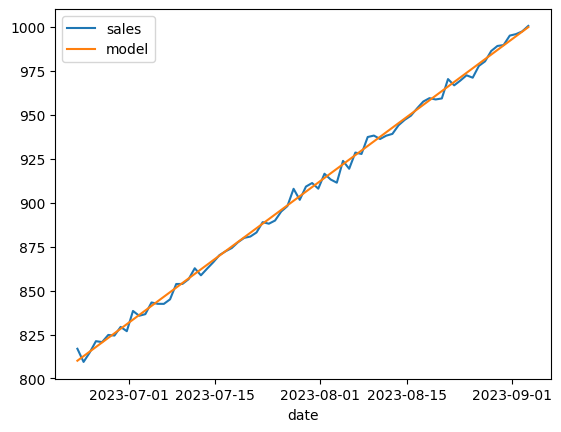

In [51]:
sns.lineplot(test)
sns.lineplot(ypred, label='model')